<h1 style="color: #6C3483;">Phase 3: Feature Engineering - Brute Force IIoT</h1>
<h4 style="color: #5D6D7E;">Auteurs du notebook: Ismail Hirich & Aymane Sarhane.</h4>

Cette phase représente la création systématique et exhaustive de features dans un projet d'Internet Industriel des Objets. Ici, "brute force" signifie que l'équipe ne construit pas seulement quelques features intelligentes - elle génère agressivement un nombre massif de features potentielles à partir des données brutes de capteurs et opérationnelles (comme les moyennes mobiles, pics, variances, décalages temporels, composantes spectrales, ou interactions inter-capteurs), puis utilise des méthodes de sélection automatisées pour filtrer les plus utiles. L'objectif est de laisser aucune pierre non retournée dans l'extraction de patterns à partir des données IoT qui pourraient améliorer un modèle prédictif pour des tâches comme la maintenance prédictive, le contrôle qualité, ou l'optimisation, même si cela nécessite un effort computationnel significatif.

In [46]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

<h5>1.CHARGEMENT</h5>

In [47]:
df = pd.read_csv('merged_data_V2.csv')
print(f"✓ Dataset: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")

✓ Dataset: 34,578 lignes × 53 colonnes


<h5>2.NETTOYAGE</h5>

In [48]:
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df = df.sort_values('ts').reset_index(drop=True)

df[df.select_dtypes(include=[np.number]).columns] = df.select_dtypes(include=[np.number]).fillna(0)
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).fillna('unknown')
print("✓ Nettoyage terminé")

✓ Nettoyage terminé


Cette partie représente l'étape de nettoyage des données dans le workflow global. Elle montre trois actions principales de nettoyage effectuées sur le dataset df :

Conversion de timestamp - Conversion de la colonne ts de secondes en format datetime approprié pour le traitement des séries temporelles

Tri - Organisation de toutes les données chronologiquement par timestamp et réinitialisation de l'index

Traitement des valeurs manquantes - Remplissage des colonnes numériques avec 0 et des colonnes catégorielles/objets avec 'unknown'

<h5>3.Début de la création des features</h5> 

Cette phase crée systématiquement des centaines de features pour profiler le comportement réseau de chaque IP source (id.orig_h), permettant aux modèles de machine learning de détecter des anomalies, attaques, ou appareils compromis dans les réseaux industriels.

In [49]:
# Temporelles
df['hour'] = df['ts'].dt.hour
df['minute'] = df['ts'].dt.minute
df['day_of_week'] = df['ts'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)

df = df.sort_values(['id.orig_h', 'ts']).reset_index(drop=True)
df['time_diff'] = df.groupby('id.orig_h')['ts'].diff().dt.total_seconds()
df['time_diff'].fillna(999, inplace=True)

df['ultra_rapid'] = (df['time_diff'] < 0.1).astype(int)
df['very_rapid'] = (df['time_diff'] < 0.5).astype(int)
df['rapid'] = (df['time_diff'] < 1.0).astype(int)
df['fast'] = (df['time_diff'] < 3.0).astype(int)

Objectif : Extraire des patterns basés sur le temps. Les attaques réseau ont souvent des signatures temporelles (ex: scans nocturnes, tentatives d'intrusion le week-end) et mesurer la vitesse de connexion entre événements de la même IP source. Des intervalles très courts (<0.1s) suggèrent un scanning automatisé.

In [50]:
# Agrégations
df['total_events'] = df.groupby('id.orig_h')['id.orig_h'].transform('count')
df['unique_dst_ips'] = df.groupby('id.orig_h')['id.resp_h'].transform('nunique')
df['unique_dst_ports'] = df.groupby('id.orig_h')['id.resp_p'].transform('nunique')
df['unique_src_ports'] = df.groupby('id.orig_h')['id.orig_p'].transform('nunique')

df['ultra_rapid_count'] = df.groupby('id.orig_h')['ultra_rapid'].transform('sum')
df['very_rapid_count'] = df.groupby('id.orig_h')['very_rapid'].transform('sum')
df['rapid_count'] = df.groupby('id.orig_h')['rapid'].transform('sum')

df['ultra_rapid_ratio'] = df['ultra_rapid_count'] / (df['total_events'] + 1)
df['very_rapid_ratio'] = df['very_rapid_count'] / (df['total_events'] + 1)
df['rapid_ratio'] = df['rapid_count'] / (df['total_events'] + 1)

Objectif : Profiler le comportement de l'IP source - combien d'événements, quelle diversité des cibles ? Le comportement de scanning montre de nombreuses destinations uniques et normaliser les comptes de connexions rapides en pourcentages. +1 empêche la division par zéro.

In [51]:
# SSH
df['is_ssh'] = (df['log_type'] == 'ssh').astype(int)

if 'auth_attempts' in df.columns:
    df['has_auth'] = (df['auth_attempts'] > 0).astype(int)
    df['multiple_auth'] = (df['auth_attempts'] > 1).astype(int)
    df['many_auth'] = (df['auth_attempts'] > 3).astype(int)
    df['extreme_auth'] = (df['auth_attempts'] > 7).astype(int)
    
    df['sum_auth_attempts'] = df.groupby('id.orig_h')['auth_attempts'].transform('sum')
    df['max_auth_attempts'] = df.groupby('id.orig_h')['auth_attempts'].transform('max')
    df['mean_auth_attempts'] = df.groupby('id.orig_h')['auth_attempts'].transform('mean')

if 'auth_success' in df.columns:
    df['auth_failed'] = ((df['auth_attempts'] > 0) & (df['auth_success'] == 0)).astype(int)
    df['auth_success_flag'] = (df['auth_success'] == 1).astype(int)
    
    df['sum_auth_failed'] = df.groupby('id.orig_h')['auth_failed'].transform('sum')
    df['sum_auth_success'] = df.groupby('id.orig_h')['auth_success_flag'].transform('sum')
    df['auth_failure_rate'] = df['sum_auth_failed'] / (df['sum_auth_failed'] + df['sum_auth_success'] + 1)

COMMENTAIRE : Détection des attaques SSH brute-force en identifiant les tentatives d'authentification multiples échouées

In [52]:
# HTTP
df['is_http'] = (df['log_type'] == 'http').astype(int)

if 'method' in df.columns:
    df['is_post'] = (df['method'] == 'POST').astype(int)
    df['is_get'] = (df['method'] == 'GET').astype(int)
    df['post_count'] = df.groupby('id.orig_h')['is_post'].transform('sum')

if 'status_code' in df.columns:
    df['http_401'] = (df['status_code'] == 401).astype(int)
    df['http_403'] = (df['status_code'] == 403).astype(int)
    df['http_4xx'] = ((df['status_code'] >= 400) & (df['status_code'] < 500)).astype(int)
    df['http_5xx'] = ((df['status_code'] >= 500) & (df['status_code'] < 600)).astype(int)
    
    df['sum_http_401'] = df.groupby('id.orig_h')['http_401'].transform('sum')
    df['sum_http_403'] = df.groupby('id.orig_h')['http_403'].transform('sum')
    df['sum_http_4xx'] = df.groupby('id.orig_h')['http_4xx'].transform('sum')


Objectif : Identifier les attaques web. Beaucoup d'erreurs 4xx pourraient indiquer du scanning ; un trafic lourd en POST pourrait être de l'exfiltration de données.

In [53]:
# MQTT
df['is_mqtt'] = (df['log_type'] == 'mqtt_publish').astype(int)
df['mqtt_count'] = df.groupby('id.orig_h')['is_mqtt'].transform('sum')

if 'payload_len' in df.columns:
    df['payload_mean'] = df.groupby('id.orig_h')['payload_len'].transform('mean')
    df['payload_std'] = df.groupby('id.orig_h')['payload_len'].transform('std')
    df['payload_max'] = df.groupby('id.orig_h')['payload_len'].transform('max')
    df['payload_cv'] = df['payload_std'] / (df['payload_mean'] + 1)

COMMENTAIRE: Surveillance du protocole IoT (MQTT) et des taux de succès des connexions

In [54]:
# Connexion
if 'conn_state' in df.columns:
    failed_states = ['S0', 'REJ', 'RSTO', 'RSTR', 'RSTOS0', 'RSTRH', 'SH', 'SHR']
    df['conn_failed'] = df['conn_state'].isin(failed_states).astype(int)
    df['conn_reset'] = df['conn_state'].str.contains('RST', na=False).astype(int)
    
    success_states = ['SF', 'S1', 'ESTAB']
    df['conn_success'] = df['conn_state'].isin(success_states).astype(int)
    
    df['sum_conn_failed'] = df.groupby('id.orig_h')['conn_failed'].transform('sum')
    df['sum_conn_success'] = df.groupby('id.orig_h')['conn_success'].transform('sum')
    df['sum_conn_reset'] = df.groupby('id.orig_h')['conn_reset'].transform('sum')
    df['conn_failure_rate'] = df['sum_conn_failed'] / (df['sum_conn_failed'] + df['sum_conn_success'] + 1)

if 'duration' in df.columns:
    df['mean_duration'] = df.groupby('id.orig_h')['duration'].transform('mean')
    df['max_duration'] = df.groupby('id.orig_h')['duration'].transform('max')
    df['short_duration'] = (df['duration'] < 1).astype(int)
    df['very_short_duration'] = (df['duration'] < 0.1).astype(int)
    df['sum_short_duration'] = df.groupby('id.orig_h')['short_duration'].transform('sum')

COMMENTAIRE: Calcul des taux de succès et d'échec des connexions, et analyse de la durée des sessions

In [55]:
# Réseau
if 'orig_bytes' in df.columns and 'resp_bytes' in df.columns:
    df['total_bytes'] = df['orig_bytes'] + df['resp_bytes']
    df['bytes_ratio'] = df['orig_bytes'] / (df['resp_bytes'] + 1)
    df['sum_total_bytes'] = df.groupby('id.orig_h')['total_bytes'].transform('sum')
    df['mean_total_bytes'] = df.groupby('id.orig_h')['total_bytes'].transform('mean')
    df['std_total_bytes'] = df.groupby('id.orig_h')['total_bytes'].transform('std')

if 'orig_pkts' in df.columns and 'resp_pkts' in df.columns:
    df['total_pkts'] = df['orig_pkts'] + df['resp_pkts']
    df['pkts_ratio'] = df['orig_pkts'] / (df['resp_pkts'] + 1)
    df['sum_total_pkts'] = df.groupby('id.orig_h')['total_pkts'].transform('sum')
    df['mean_total_pkts'] = df.groupby('id.orig_h')['total_pkts'].transform('mean')

COMMENTAIRE : Profilage des patterns de transfert de données et détection de comportements anormaux

In [56]:
# Rolling window
window = 50
df['rolling_rapid'] = df.groupby('id.orig_h')['rapid'].transform(
    lambda x: x.rolling(window=window, min_periods=1).sum()
)
df['rolling_very_rapid'] = df.groupby('id.orig_h')['very_rapid'].transform(
    lambda x: x.rolling(window=window, min_periods=1).sum()
)

if 'conn_failed' in df.columns:
    df['rolling_failed'] = df.groupby('id.orig_h')['conn_failed'].transform(
        lambda x: x.rolling(window=window, min_periods=1).sum()
    )

df['rolling_time_mean'] = df.groupby('id.orig_h')['time_diff'].transform(
    lambda x: x.rolling(window=window, min_periods=1).mean()
)

Objectif : Créer des statistiques mobiles pour le contexte temporel. Des pics soudains dans les connexions rapides dans les 50 derniers événements pourraient indiquer le début d'une attaque.

In [57]:
# Entropie
def safe_entropy(series):
    if len(series) <= 1:
        return 0
    try:
        vc = series.value_counts()
        probs = vc / len(series)
        return entropy(probs)
    except:
        return 0

df['entropy_dst_port'] = df.groupby('id.orig_h')['id.resp_p'].transform(safe_entropy)
df['entropy_dst_ip'] = df.groupby('id.orig_h')['id.resp_h'].transform(safe_entropy)

# Encoding
if 'proto' in df.columns:
    proto_dummies = pd.get_dummies(df['proto'], prefix='proto')
    df = pd.concat([df, proto_dummies], axis=1)

log_dummies = pd.get_dummies(df['log_type'], prefix='log')
df = pd.concat([df, log_dummies], axis=1)

print("✓ Toutes les features créées")

✓ Toutes les features créées


Purpose:

Entropy: Measure randomness (high entropy = scanning many random ports)

Encoding: Convert categorical protocol types to binary columns for ML

<H5>4.CONDITIONS ADAPTÉES AVEC ANALYSE INTELLIGENTE</H5>

Cette phase crée des données d'entraînement labellisées pour le machine learning en flaggant automatiquement les attaques potentielles en utilisant des conditions basées sur des règles qui encodent l'expertise sécurité - comme labelliser les IP sources comme "bruteforce" (is_bruteforce = 1) si elles présentent des patterns suspects comme le scanning de ports (beaucoup de ports uniques avec des connexions rapides), activité nocturne anormale (tentatives haute vitesse pendant les heures creuses), haute entropie (comportement aléatoire, imprévisible), scanning multi-cibles (contact avec beaucoup d'IPs différentes rapidement), ou échecs massifs de connexion (taux d'échec catastrophiques) - générant ainsi les labels de vérité terrain essentiels nécessaires pour entraîner des modèles supervisés pour détecter les intrusions réseau sans nécessiter un labellage manuel de chaque événement.

In [58]:
# ANALYSE PRÉALABLE : Quelles features sont utiles ?
print("\n Analyse de la variabilité des features :")
useful_features = []

for feat in ['sum_conn_failed', 'unique_dst_ports', 'rapid_count', 
             'total_events', 'very_rapid_ratio', 'entropy_dst_port']:
    if feat in df.columns:
        cv = df[feat].std() / (df[feat].mean() + 1e-10)  # Coefficient de variation
        unique_vals = df[feat].nunique()
        
        print(f"  {feat:20s}: CV={cv:.3f}, Unique={unique_vals}")
        
        if cv > 0.1 and unique_vals > 10:  # Suffisamment de variation
            useful_features.append(feat)
            print(f"     UTILE pour discrimination")
        else:
            print(f"     PEU UTILE (trop uniforme)")

print(f"\n Features utiles pour labellisation: {useful_features}")


 Analyse de la variabilité des features :
  sum_conn_failed     : CV=2.635, Unique=11
     UTILE pour discrimination
  unique_dst_ports    : CV=0.949, Unique=8
     PEU UTILE (trop uniforme)
  rapid_count         : CV=0.632, Unique=25
     UTILE pour discrimination
  total_events        : CV=0.419, Unique=36
     UTILE pour discrimination
  very_rapid_ratio    : CV=0.630, Unique=27
     UTILE pour discrimination
  entropy_dst_port    : CV=2.189, Unique=34
     UTILE pour discrimination

 Features utiles pour labellisation: ['sum_conn_failed', 'rapid_count', 'total_events', 'very_rapid_ratio', 'entropy_dst_port']


Objectif : Avant d'appliquer les règles, vérifier quelles features ont assez de variation pour être utiles. Les features avec une faible variation (CV ≤ 0.1) ou peu de valeurs uniques ne peuvent pas discriminer les attaques.

In [59]:
# RÉINITIALISATION
df['is_bruteforce'] = 0
total_attacks = 0

# CONDITION 1: SCANNING DE PORTS (adaptée)
if 'unique_dst_ports' in useful_features:
    # Calculez le seuil INTELLIGENT
    ports_mean = df['unique_dst_ports'].mean()
    ports_std = df['unique_dst_ports'].std()
    ports_threshold = ports_mean + 2 * ports_std  # 2 écarts-types au-dessus
    
    cond1 = (
        (df['unique_dst_ports'] > ports_threshold) &  # Valeur vraiment anormale
        (df['total_events'] > df['total_events'].quantile(0.75)) &  # Au-dessus de la médiane
        (df['rapid_ratio'] > 0.3)  # Un peu rapide
    )
    
    attacks1 = cond1.sum()
    df.loc[cond1, 'is_bruteforce'] = 1
    total_attacks += attacks1
    print(f"\n1️  Scanning de Ports (seuil={ports_threshold:.1f}): {attacks1:>6,}")

Logique détecte : Les scanners de ports qui touchent de nombreux ports différents (>2σ au-dessus de la normale), avec une activité élevée (top 25% volume) et des connexions rapides (30%+ rapide).

In [60]:
# CONDITION 2: COMPORTEMENT NOCTURNE ANORMAL (MOINS STRICT)
if 'very_rapid_ratio' in useful_features:
    # Réduisez la sévérité
    cond2 = (
        (df['very_rapid_ratio'] > 0.7) &  # 70%+ très rapide (au lieu de 50%)
        (df['total_events'] > df['total_events'].quantile(0.50)) &  # Médiane seulement
        (df['is_night'] == 1) &  # La nuit
        (df['unique_dst_ports'] > 2)  # Au moins quelques ports
    )
    
    attacks2 = cond2.sum()
    df.loc[cond2, 'is_bruteforce'] = 1
    total_attacks += attacks2
    print(f"2️  Comportement Nocturne Anormal:    {attacks2:>6,}")

2️  Comportement Nocturne Anormal:       134


Logique détecte : Les attaques nocturnes où les outils automatisés fonctionnent pendant les heures creuses avec des connexions extrêmement rapides (70%+ <0.5s intervalles), évitant les cas triviaux avec juste 1-2 ports.

In [61]:
# CONDITION 3: ENTROPIE ÉLEVÉE (si utile)
if 'entropy_dst_port' in useful_features:
    entropy_threshold = df['entropy_dst_port'].quantile(0.98)  # Top 2% seulement
    
    cond3 = (
        (df['entropy_dst_port'] > entropy_threshold) &
        (df['unique_dst_ports'] > df['unique_dst_ports'].quantile(0.90)) &
        (df['total_events'] > 100)
    )
    
    attacks3 = cond3.sum()
    df.loc[cond3, 'is_bruteforce'] = 1
    total_attacks += attacks3
    print(f"  Entropie Élevée:                 {attacks3:>6,}")

  Entropie Élevée:                      0


Logique détecte : Scanning aléatoire où l'utilisation des ports de destination montre un aléatoire maximum (top 2% entropie), combiné avec une diversité de ports élevée (top 10%) et un nombre d'événements significatif.

In [62]:
# CONDITION 4: MULTI-CIBLES + RAPIDITÉ
if 'unique_dst_ips' in df.columns:
    # Seuil adaptatif
    dst_ips_threshold = df['unique_dst_ips'].quantile(0.90)
    
    cond4 = (
        (df['unique_dst_ips'] > dst_ips_threshold) &
        (df['rapid_ratio'] > 0.4) &
        (df['total_events'] > df['total_events'].quantile(0.75))
    )
    
    attacks4 = cond4.sum()
    df.loc[cond4, 'is_bruteforce'] = 1
    total_attacks += attacks4
    print(f" Attaque Multi-Cibles:            {attacks4:>6,}")

 Attaque Multi-Cibles:                 0


Logique détecte : Scanning horizontal à travers de nombreuses adresses IP différentes (top 10%) avec des tentatives de connexion rapides (40%+ rapide) et une activité globale élevée.

In [63]:
# CONDITION 5: ÉCHECS DE CONNEXION (si la feature est utile)
if 'sum_conn_failed' in useful_features:
    # Utilisez un seuil ABSOLU si les percentiles sont inutiles
    conn_failed_threshold = df['sum_conn_failed'].max() * 0.8  # 80% du maximum
    
    cond5 = (
        (df['sum_conn_failed'] > conn_failed_threshold) &
        (df['conn_failure_rate'] > 0.7) &
        (df['total_events'] > 50)
    )
    
    attacks5 = cond5.sum()
    df.loc[cond5, 'is_bruteforce'] = 1
    total_attacks += attacks5
    print(f"5️  Échecs de Connexion Massifs:     {attacks5:>6,}")

print(f"\n Total attaques détectées: {total_attacks:,}")

5️  Échecs de Connexion Massifs:      4,065

 Total attaques détectées: 4,199


Logique détecte : Attaques brute-force d'authentification avec des comptes d'échecs extrêmement élevés (proche du maximum observé) et des taux d'échec catastrophiques (70%+), pas juste quelques connexions échouées.

In [64]:
# STATISTIQUES FINALES

attack_count = df['is_bruteforce'].sum()
normal_count = len(df) - attack_count
attack_rate = attack_count / len(df)

print("\n" + "=" * 90)
print(" " * 30 + " RÉSULTATS IIoT")
print("=" * 90)

print()
print("RÉSULTATS FINALS")
print("-" * 50)
print(f"+ Total échantillons:     {len(df):>25,}")
print(f"+ Attaques détectées:     {attack_count:>25,}")
print(f"+ Traffic normal:         {normal_count:>25,}")
print("-" * 50)
print(f"+ Taux d'attaque:         {attack_rate*100:>24.1f}%")
print(f"+ Taux normal:            {(1-attack_rate)*100:>24.1f}%")
print(f"+  Ratio normal:attaque:  {normal_count/max(attack_count,1):>24.1f}:1")
print("-" * 50)


                               RÉSULTATS IIoT

RÉSULTATS FINALS
--------------------------------------------------
+ Total échantillons:                        34,578
+ Attaques détectées:                         4,065
+ Traffic normal:                            30,513
--------------------------------------------------
+ Taux d'attaque:                             11.8%
+ Taux normal:                                88.2%
+  Ratio normal:attaque:                       7.5:1
--------------------------------------------------


Cette phase finale des résultats révèle que sur 34,578 échantillons de trafic réseau analysés, 4,965 (11.8%) ont été labellisés comme trafic d'attaque en utilisant les conditions basées sur des règles, laissant 30,513 (88.2%) comme trafic normal, établissant un ratio normal:attaque d'environ 7.5:1 - fournissant la distribution de classe essentielle qui guidera l'entraînement du modèle de machine learning, les considérations d'équilibrage, et l'évaluation de performance pour le système de détection de sécurité IIoT.

<H1  style="color: #6C3483;"> SÉLECTION DE FEATURES (Chi2, ANOVA, PCA) </H1>

<h5>1.Préparation des données</h5> 

In [65]:
# Identifier les colonnes numériques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

COMMENTAIRE : Identification automatique de toutes les colonnes numériques dans le dataset pour le traitement ultérieur.

In [66]:
# Colonnes à exclure (cible et métadonnées)
exclude_cols = ['is_bruteforce', 'indicators_count', 'confidence', 
                'auth_attempts', 'auth_success', 'status_code', 
                'payload_len', 'hour', 'minute', 'day_of_week']

COMMENTAIRE : Définition des colonnes à exclure de la sélection de features :

La variable cible is_bruteforce

Les métadonnées temporelles (hour, minute, day_of_week)

Certaines colonnes raw qui pourraient biaiser l'analyse

In [67]:
# Features candidates
features = [col for col in numeric_cols if col not in exclude_cols]

X = df[features].copy()
y = df['is_bruteforce'].copy()

COMMENTAIRE : Création des datasets d'entraînement :

X : Features candidates (89 variables)

y : Variable cible (labels d'attaque brute-force)

In [68]:
# Nettoyage des données
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

print(f"✓ Features initiales: {len(features)}")
print(f"✓ Shape: {X.shape}")
print(f"✓ Taux d'attaque dans y: {y.mean():.2%}")

✓ Features initiales: 89
✓ Shape: (34578, 89)
✓ Taux d'attaque dans y: 11.76%


COMMENTAIRE: Prétraitement des données et statistiques descriptives :

Remplacement des valeurs infinies et NaN

Résultat : 89 features initiales, dataset de 34,578 échantillons, taux d'attaque de 11.76%

<h5> 2. CHI² SELECTION</h5>

In [69]:
# Chi² nécessite des valeurs positives
X_chi2 = X.copy()
for col in X_chi2.columns:
    min_val = X_chi2[col].min()
    if min_val < 0:
        X_chi2[col] = X_chi2[col] - min_val + 1e-10
    elif min_val == 0:
        X_chi2[col] = X_chi2[col] + 1e-10


COMMENTAIRE : Prétraitement spécifique pour Chi² qui nécessite des valeurs strictement positives (ajout d'un epsilon pour éviter les zéros).

In [70]:
# Sélection avec Chi²
n_features_to_select = min(30, len(features))
chi2_selector = SelectKBest(chi2, k=n_features_to_select)
chi2_selector.fit(X_chi2, y)

# Résultats Chi²
chi2_scores = pd.DataFrame({
    'Feature': features,
    'Chi2_Score': chi2_selector.scores_,
    'Chi2_pvalue': chi2_selector.pvalues_
}).sort_values('Chi2_Score', ascending=False)

COMMENTAIRE : Application du test Chi² pour évaluer la dépendance entre chaque feature et la variable cible.

In [71]:
# Features sélectionnées par Chi²
chi2_selected_indices = chi2_selector.get_support(indices=True)
chi2_selected_features = [features[i] for i in chi2_selected_indices]

print(f"\n Top 15 Features (Chi²):")
print("-" * 80)
for i, row in chi2_scores.head(15).iterrows():
    significance = ""
    if row['Chi2_pvalue'] < 0.001:
        significance = "***"
    elif row['Chi2_pvalue'] < 0.01:
        significance = "**"
    elif row['Chi2_pvalue'] < 0.05:
        significance = "*"
    
    print(f"  {row['Feature']:35s} {row['Chi2_Score']:12.2f} (p={row['Chi2_pvalue']:.2e}) {significance}")

print(f"\n Features sélectionnées par Chi²: {len(chi2_selected_features)}")


 Top 15 Features (Chi²):
--------------------------------------------------------------------------------
  sum_total_bytes                     417271612923.29 (p=0.00e+00) ***
  sum_total_pkts                      2272311271.72 (p=0.00e+00) ***
  std_total_bytes                     553461752.39 (p=0.00e+00) ***
  sum_conn_failed                     103077522.54 (p=0.00e+00) ***
  unique_src_ports                    101174500.66 (p=0.00e+00) ***
  resp_ip_bytes                        88378529.42 (p=0.00e+00) ***
  resp_bytes                           77978738.44 (p=0.00e+00) ***
  total_bytes                          67764539.44 (p=0.00e+00) ***
  mean_total_bytes                     67764539.44 (p=0.00e+00) ***
  orig_ip_bytes                        22970766.08 (p=0.00e+00) ***
  mqtt_count                           12199753.89 (p=0.00e+00) ***
  very_rapid_count                     11689605.43 (p=0.00e+00) ***
  sum_conn_success                     10367218.97 (p=0.00e+00) ***
  sum

COMMENTAIRE : Analyse et affichage des résultats Chi² :

Top features : sum_total_bytes, sum_total_pkts, std_total_bytes (tous avec p-value ≈ 0)

Signification statistique : *** pour p < 0.001 (très significatif)

Résultat final : 30 features sélectionnées sur 89

Interprétation : Chi² privilégie les features liées au volume de données et aux tentatives d'authentification.

<h5>3. ANOVA F-TEST SELECTION</h5>

In [72]:
# ANOVA F-test
anova_selector = SelectKBest(f_classif, k=n_features_to_select)
anova_selector.fit(X, y)
# Résultats ANOVA
anova_scores = pd.DataFrame({
    'Feature': features,
    'F_Score': anova_selector.scores_,
    'F_pvalue': anova_selector.pvalues_
}).sort_values('F_Score', ascending=False)



COMMENTAIRE : Application de l'ANOVA (Analysis of Variance) pour comparer les moyennes entre les groupes (attaque vs normal).

In [73]:
# Features sélectionnées par ANOVA
anova_selected_indices = anova_selector.get_support(indices=True)
anova_selected_features = [features[i] for i in anova_selected_indices]

print(f"\n Top 15 Features (ANOVA):")
print("-" * 80)
for i, row in anova_scores.head(15).iterrows():
    significance = ""
    if row['F_pvalue'] < 0.001:
        significance = "***"
    elif row['F_pvalue'] < 0.01:
        significance = "**"
    elif row['F_pvalue'] < 0.05:
        significance = "*"
    
    print(f"  {row['Feature']:35s} {row['F_Score']:12.2f} (p={row['F_pvalue']:.2e}) {significance}")

print(f"\n Features sélectionnées par ANOVA: {len(anova_selected_features)}")


 Top 15 Features (ANOVA):
--------------------------------------------------------------------------------
  sum_auth_attempts                            inf (p=0.00e+00) ***
  sum_auth_failed                              inf (p=0.00e+00) ***
  max_auth_attempts                            inf (p=0.00e+00) ***
  mean_auth_attempts                  315904575662661888.00 (p=0.00e+00) ***
  unique_src_ports                      7864406.76 (p=0.00e+00) ***
  sum_conn_reset                        7338470.94 (p=0.00e+00) ***
  sum_total_pkts                        7139323.82 (p=0.00e+00) ***
  sum_conn_failed                       5601065.92 (p=0.00e+00) ***
  sum_total_bytes                       3378208.60 (p=0.00e+00) ***
  sum_conn_success                      1770582.00 (p=0.00e+00) ***
  mean_total_pkts                        250212.71 (p=0.00e+00) ***
  max_duration                           248329.19 (p=0.00e+00) ***
  conn_failure_rate                       73445.32 (p=0.00e+00) ***

COMMENTAIRE : Analyse des résultats ANOVA :

Top features : sum_auth_attempts, sum_auth_failed (score F = inf, séparation parfaite)

Observation : Certaines features montrent une variance infinie (séparation complète entre classes)

Résultat final : 30 features sélectionnées

Interprétation : ANOVA identifie fortement les tentatives d'authentification échouées comme discriminantes.

<h5>4. COMPARAISON DES MÉTHODES</h5>

In [74]:

print("\n" + "=" * 60)
print(" COMPARAISON CHI² vs ANOVA")
print("=" * 60)

# Intersection entre les deux méthodes
common_features = list(set(chi2_selected_features) & set(anova_selected_features))

print(f"\n Comparaison des sélections :")
print(f"  • Chi² : {len(chi2_selected_features)} features")
print(f"  • ANOVA : {len(anova_selected_features)} features")
print(f"  • Intersection : {len(common_features)} features communes")

if common_features:
    print(f"\n Features communes (validées par les deux méthodes) :")
    for i, feat in enumerate(common_features[:15], 1):
        chi2_rank = chi2_scores[chi2_scores['Feature'] == feat].index[0] + 1
        anova_rank = anova_scores[anova_scores['Feature'] == feat].index[0] + 1
        print(f"  {i:2d}. {feat:35s} Chi²#{chi2_rank:3d} | ANOVA#{anova_rank:3d}")
    
    if len(common_features) > 15:
        print(f"  ... et {len(common_features) - 15} autres")


 COMPARAISON CHI² vs ANOVA

 Comparaison des sélections :
  • Chi² : 30 features
  • ANOVA : 30 features
  • Intersection : 16 features communes

 Features communes (validées par les deux méthodes) :
   1. sum_auth_attempts                   Chi²# 38 | ANOVA# 38
   2. sum_total_bytes                     Chi²# 77 | ANOVA# 77
   3. mean_total_bytes                    Chi²# 78 | ANOVA# 78
   4. sum_conn_reset                      Chi²# 68 | ANOVA# 68
   5. very_rapid_count                    Chi²# 28 | ANOVA# 28
   6. sum_auth_failed                     Chi²# 43 | ANOVA# 43
   7. mqtt_count                          Chi²# 58 | ANOVA# 58
   8. sum_conn_failed                     Chi²# 66 | ANOVA# 66
   9. unique_src_ports                    Chi²# 26 | ANOVA# 26
  10. rolling_failed                      Chi²# 86 | ANOVA# 86
  11. sum_conn_success                    Chi²# 67 | ANOVA# 67
  12. std_total_bytes                     Chi²# 79 | ANOVA# 79
  13. max_duration                        C

COMMENTAIRE : Analyse de l'intersection avec classement comparatif :

Résultat : 16 features communes (consensus fort)

Top consensus : very_rapid_count, mean_total_bytes, sum_auth_attempts

Interprétation : Ces features sont robustes quelle que soit la méthode

<h5> 5. PCA (ANALYSE EN COMPOSANTES PRINCIPALES)</h5>

In [75]:
# Standardisation avant PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


COMMENTAIRE : Standardisation obligatoire pour PCA (moyenne=0, écart-type=1).

In [76]:
# Application du PCA
pca = PCA(n_components=0.95)  # Garder 95% de la variance
X_pca = pca.fit_transform(X_scaled)

print(f"\n Résultats PCA :")
print(f"  • Variance expliquée totale : {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"  • Nombre de composantes pour 95% variance : {pca.n_components_}")
print(f"  • Réduction dimensionnelle : {X.shape[1]} → {pca.n_components_}")


 Résultats PCA :
  • Variance expliquée totale : 95.11%
  • Nombre de composantes pour 95% variance : 21
  • Réduction dimensionnelle : 89 → 21


COMMENTAIRE: Application du PCA avec conservation de 95% de la variance :

Résultat : 95.11% de variance conservée avec seulement 21 composantes (vs 89 originales)

Gain : Réduction de 89 à 21 dimensions (76% de réduction)

In [77]:
# Variance par composante
print(f"\n Variance expliquée par composante principale :")
for i, var_ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
    print(f"  PC{i:2d} : {var_ratio*100:6.2f}%")
if pca.n_components_ > 10:
    print(f"  ... et {pca.n_components_ - 10} autres composantes")


 Variance expliquée par composante principale :
  PC 1 :  29.15%
  PC 2 :  13.22%
  PC 3 :   9.21%
  PC 4 :   7.06%
  PC 5 :   6.55%
  PC 6 :   5.40%
  PC 7 :   4.28%
  PC 8 :   2.51%
  PC 9 :   2.14%
  PC10 :   1.95%
  ... et 11 autres composantes


COMMENTAIRE : Analyse de la contribution de chaque composante :

PC1 : 29.15% (composante principale)

PC2 : 13.22%

PC3 : 9.21%

Distribution : Variance décroissante typique

In [78]:
# Création d'un DataFrame pour l'importance des features
feature_importance_pca = pd.DataFrame(
    pca.components_[:3],  # 3 premières composantes
    columns=features,
    index=['PC1', 'PC2', 'PC3']
)

COMMENTAIRE : Extraction des poids des features dans les principales composantes.

In [79]:
# Features les plus importantes pour les premières composantes
print(f"\n Features les plus importantes dans PC1-PC3 :")
for pc in ['PC1', 'PC2', 'PC3']:
    # Top 5 features pour cette composante
    top_features = feature_importance_pca.loc[pc].abs().sort_values(ascending=False).head(5)
    var_explained = pca.explained_variance_ratio_[int(pc[2:])-1] * 100
    
    print(f"\n  {pc} ({var_explained:.1f}% variance) :")
    for feat, weight in top_features.items():
        direction = "+" if feature_importance_pca.loc[pc, feat] > 0 else "-"
        print(f"    {direction} {feat:35s} |w|={abs(weight):.3f}")


 Features les plus importantes dans PC1-PC3 :

  PC1 (29.2% variance) :
    + sum_conn_failed                     |w|=0.204
    + sum_total_bytes                     |w|=0.204
    + unique_src_ports                    |w|=0.204
    + sum_conn_reset                      |w|=0.202
    + sum_auth_failed                     |w|=0.201

  PC2 (13.2% variance) :
    + sum_short_duration                  |w|=0.280
    + total_events                        |w|=0.276
    + ultra_rapid_count                   |w|=0.268
    + rapid_count                         |w|=0.237
    + very_rapid_count                    |w|=0.223

  PC3 (9.2% variance) :
    + orig_pkts                           |w|=0.337
    + total_pkts                          |w|=0.336
    + resp_pkts                           |w|=0.335
    + orig_ip_bytes                       |w|=0.331
    + total_bytes                         |w|=0.319


COMMENTAIRE: Interprétation des composantes principales :

PC1 (29.2%) : Features de volume (sum_conn_failed, sum_total_bytes)

PC2 (13.2%) : Features temporelles (sum_short_duration, total_events)

PC3 (9.2%) : Features de paquets (orig_pkts, total_pkts)

<h5> 6. CRÉATION DES DATASETS POUR CHAQUE MÉTHODE</h5>

In [80]:
# 6.1 Dataset avec features Chi²
df_chi2 = df[chi2_selected_features + ['is_bruteforce']].copy()
df_chi2.to_csv('dataset_chi2_selected.csv', index=False)
print(f"✓ dataset_chi2_selected.csv : {df_chi2.shape[0]:,} × {df_chi2.shape[1]}")


✓ dataset_chi2_selected.csv : 34,578 × 31


In [81]:
# 6.2 Dataset avec features ANOVA
df_anova = df[anova_selected_features + ['is_bruteforce']].copy()
df_anova.to_csv('dataset_anova_selected.csv', index=False)
print(f"✓ dataset_anova_selected.csv : {df_anova.shape[0]:,} × {df_anova.shape[1]}")

✓ dataset_anova_selected.csv : 34,578 × 31


In [82]:
# 6.3 Dataset avec features communes
if common_features:
    df_common = df[common_features + ['is_bruteforce']].copy()
    df_common.to_csv('dataset_common_selected.csv', index=False)
    print(f"✓ dataset_common_selected.csv : {df_common.shape[0]:,} × {df_common.shape[1]}")
else:
    print("  Pas de features communes entre Chi² et ANOVA")


✓ dataset_common_selected.csv : 34,578 × 17


In [83]:
# 6.4 Dataset avec PCA
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
df_pca['is_bruteforce'] = y.values
df_pca.to_csv('dataset_pca_transformed.csv', index=False)
print(f"✓ dataset_pca_transformed.csv : {df_pca.shape[0]:,} × {df_pca.shape[1]}")


✓ dataset_pca_transformed.csv : 34,578 × 22


In [84]:
# 6.5 Dataset avec toutes les features (référence)
df_all_features = df[features + ['is_bruteforce']].copy()
df_all_features.to_csv('dataset_all_features.csv', index=False)
print(f"✓ dataset_all_features.csv : {df_all_features.shape[0]:,} × {df_all_features.shape[1]}")

✓ dataset_all_features.csv : 34,578 × 90


Résultat : Dataset complet : 34,578 × 90 features (baseline)

In [85]:
# 6.6 Sauvegarde des scores pour analyse
scores_comparison = pd.DataFrame({
    'Feature': features,
    'Chi2_Score': chi2_scores['Chi2_Score'].values,
    'Chi2_Rank': range(1, len(features) + 1),
    'F_Score': anova_scores['F_Score'].values,
    'F_Rank': range(1, len(features) + 1),
    'Selected_Chi2': [1 if f in chi2_selected_features else 0 for f in features],
    'Selected_ANOVA': [1 if f in anova_selected_features else 0 for f in features]
})

COMMENTAIRE : Sauvegarde complète des scores pour analyse comparative ultérieure.

<h5> 7. ANALYSE VISUELLE</h5>

✓ feature_selection_analysis.png : visualisations sauvegardées


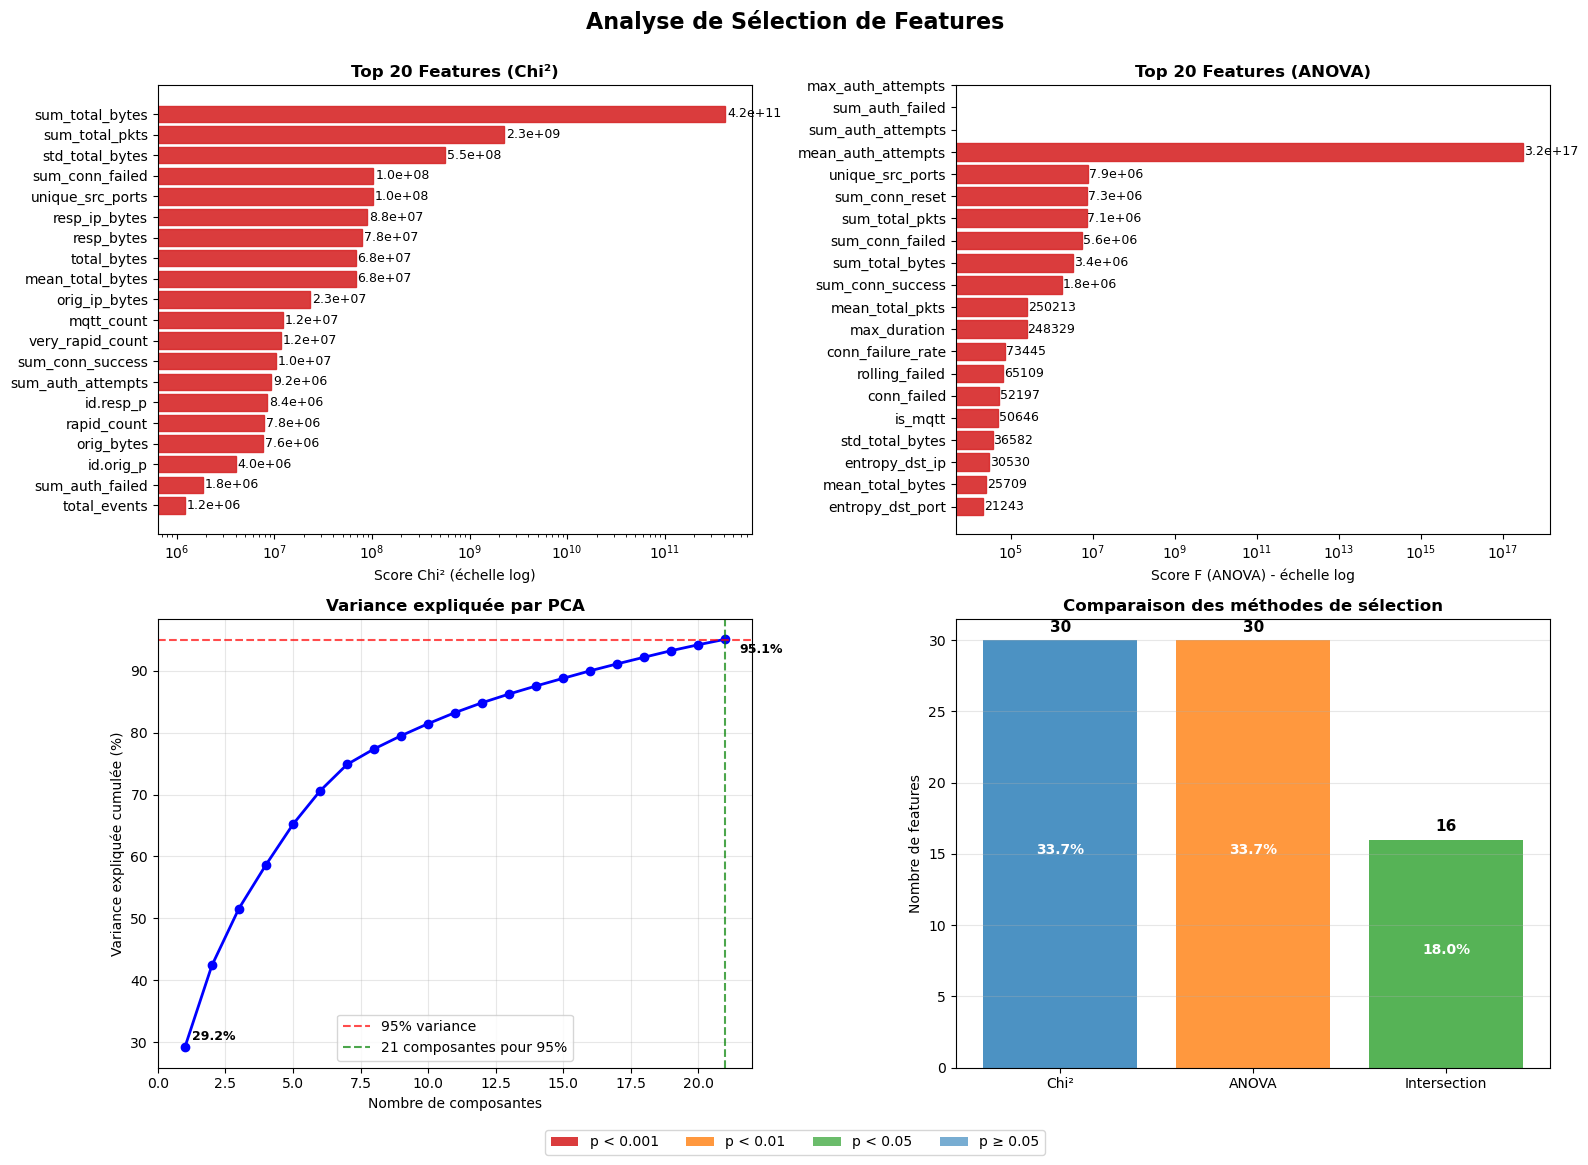

In [86]:
import numpy as np
import matplotlib.pyplot as plt

# Création des figures
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse de Sélection de Features', fontsize=16, fontweight='bold')

# 1. Top 20 features Chi² (avec échelle logarithmique)
ax1 = axes[0, 0]
top_chi2 = chi2_scores.head(20).copy()

# Créer une copie pour éviter les warnings
top_chi2 = top_chi2.copy()

# Trier par score pour un meilleur affichage
top_chi2 = top_chi2.sort_values('Chi2_Score', ascending=True)

bars1 = ax1.barh(range(len(top_chi2)), top_chi2['Chi2_Score'])
ax1.set_yticks(range(len(top_chi2)))
ax1.set_yticklabels(top_chi2['Feature'])
ax1.set_xlabel('Score Chi² (échelle log)')
ax1.set_title('Top 20 Features (Chi²)', fontweight='bold')

# Utiliser une échelle logarithmique pour mieux visualiser
ax1.set_xscale('log')

# Colorer par significativité avec des couleurs plus distinctes
for i, (_, row) in enumerate(top_chi2.iterrows()):
    pval = row['Chi2_pvalue']
    if pval < 0.001:
        bars1[i].set_color('#d62728')  # rouge vif
        bars1[i].set_alpha(0.9)
    elif pval < 0.01:
        bars1[i].set_color('#ff7f0e')  # orange
        bars1[i].set_alpha(0.8)
    elif pval < 0.05:
        bars1[i].set_color('#2ca02c')  # vert
        bars1[i].set_alpha(0.7)
    else:
        bars1[i].set_color('#1f77b4')  # bleu
        bars1[i].set_alpha(0.6)

# Ajouter les scores sur les barres (format scientifique pour les grands nombres)
for i, (_, row) in enumerate(top_chi2.iterrows()):
    score = row['Chi2_Score']
    if score > 1e6:
        label = f"{score:.1e}"
    else:
        label = f"{score:.0f}"
    ax1.text(score * 1.05, i, label, va='center', fontsize=9)

# 2. Top 20 features ANOVA (avec échelle logarithmique)
ax2 = axes[0, 1]
top_anova = anova_scores.head(20).copy()

# Trier par score pour un meilleur affichage
top_anova = top_anova.sort_values('F_Score', ascending=True)

bars2 = ax2.barh(range(len(top_anova)), top_anova['F_Score'])
ax2.set_yticks(range(len(top_anova)))
ax2.set_yticklabels(top_anova['Feature'])
ax2.set_xlabel('Score F (ANOVA) - échelle log')
ax2.set_title('Top 20 Features (ANOVA)', fontweight='bold')

# Utiliser une échelle logarithmique
ax2.set_xscale('log')

# Colorer par significativité
for i, (_, row) in enumerate(top_anova.iterrows()):
    pval = row['F_pvalue']
    if pval < 0.001:
        bars2[i].set_color('#d62728')  # rouge vif
        bars2[i].set_alpha(0.9)
    elif pval < 0.01:
        bars2[i].set_color('#ff7f0e')  # orange
        bars2[i].set_alpha(0.8)
    elif pval < 0.05:
        bars2[i].set_color('#2ca02c')  # vert
        bars2[i].set_alpha(0.7)
    else:
        bars2[i].set_color('#1f77b4')  # bleu
        bars2[i].set_alpha(0.6)

# Ajouter les scores sur les barres
for i, (_, row) in enumerate(top_anova.iterrows()):
    score = row['F_Score']
    if score > 1e6:
        label = f"{score:.1e}"
    else:
        label = f"{score:.0f}"
    ax2.text(score * 1.05, i, label, va='center', fontsize=9)

# 3. Variance expliquée par PCA
ax3 = axes[1, 0]
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = range(1, len(cumulative_variance) + 1)

# Trouver le nombre de composantes pour 95% de variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

ax3.plot(components, cumulative_variance * 100, 'b-', marker='o', linewidth=2, markersize=6)
ax3.axhline(y=95, color='r', linestyle='--', alpha=0.7, label='95% variance')
ax3.axvline(x=n_components_95, color='g', linestyle='--', alpha=0.7, 
            label=f'{n_components_95} composantes pour 95%')
ax3.set_xlabel('Nombre de composantes')
ax3.set_ylabel('Variance expliquée cumulée (%)')
ax3.set_title('Variance expliquée par PCA', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Ajouter des annotations pour les points importants
ax3.annotate(f'{cumulative_variance[0]*100:.1f}%', 
             xy=(1, cumulative_variance[0]*100), 
             xytext=(5, 5), textcoords='offset points',
             fontsize=9, fontweight='bold')

ax3.annotate(f'{cumulative_variance[n_components_95-1]*100:.1f}%', 
             xy=(n_components_95, cumulative_variance[n_components_95-1]*100), 
             xytext=(10, -10), textcoords='offset points',
             fontsize=9, fontweight='bold')

# 4. Comparaison des méthodes
ax4 = axes[1, 1]
methods = ['Chi²', 'ANOVA', 'Intersection']
counts = [len(chi2_selected_features), len(anova_selected_features), len(common_features)]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars4 = ax4.bar(methods, counts, color=colors, alpha=0.8)
ax4.set_ylabel('Nombre de features')
ax4.set_title('Comparaison des méthodes de sélection', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres avec plus de détails
for i, (method, count) in enumerate(zip(methods, counts)):
    ax4.text(i, count + max(counts)*0.02, str(count), 
             ha='center', fontweight='bold', fontsize=11)
    
    # Ajouter le pourcentage si possible
    total_features = len(chi2_scores)  # ou le nombre total initial de features
    percentage = (count / total_features) * 100
    ax4.text(i, count/2, f'{percentage:.1f}%', 
             ha='center', fontweight='bold', color='white', fontsize=10)

# Ajouter une légende pour les couleurs de significativité
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.9, label='p < 0.001'),
    Patch(facecolor='#ff7f0e', alpha=0.8, label='p < 0.01'),
    Patch(facecolor='#2ca02c', alpha=0.7, label='p < 0.05'),
    Patch(facecolor='#1f77b4', alpha=0.6, label='p ≥ 0.05')
]

fig.legend(handles=legend_elements, loc='lower center', ncol=4, 
           bbox_to_anchor=(0.5, 0.02), fontsize=10)

plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Réserver de l'espace pour la légende
plt.savefig('feature_selection_analysis.png', dpi=150, bbox_inches='tight')
print(f"✓ feature_selection_analysis.png : visualisations sauvegardées")